In [1]:
import numpy as np
import os
import glob
import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
eps = np.finfo(float).eps

import tqdm

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()

In [3]:
class CMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]
        
    def __getitem__(self, idx):
        x = self.data[idx, :]
        
        if self.transform is None:
            self.transform = T.ToTensor()
        x = self.transform(x)
                
        return x

In [4]:
def load_data(path):
    with open(path, 'rb') as fp:
        data = pickle.load(fp)
    train_valid = data['train'].astype(np.float32)
    test = data['test'].astype(np.float32)
    return train_valid, test

train_valid, x_test = load_data('../data/mnist-hw1.pkl')
x_train = train_valid[:int(len(train_valid)*0.8)]
x_valid = train_valid[int(len(train_valid)*0.8):]

batch_size = 128


transform = T.Compose([T.ToTensor()])

dataloader_train = DataLoader(CMNIST(x_train, transform=transform), batch_size=batch_size, 
                              shuffle=True, num_workers=4, pin_memory=True)

dataloader_val = DataLoader(CMNIST(x_valid, transform=transform), batch_size=batch_size,
                              shuffle=True, num_workers=4, pin_memory=True)

dataloader_test = DataLoader(CMNIST(x_test, transform=transform), batch_size=batch_size, 
                              shuffle=True, num_workers=4, pin_memory=True)


In [5]:
def type_tdouble(use_cuda=False):
    return torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor

def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)
                
def one_hot(labels, n_class, use_cuda=False):
    # Ensure labels are [N x 1]
    if len(list(labels.size())) == 1:
        labels = labels.unsqueeze(1)
    mask = type_tdouble(use_cuda)(labels.size(0), n_class).fill_(0)
    # scatter dimension, position indices, fill_value
    return mask.scatter_(1, labels, 1)

In [6]:
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kernel_height, kernel_width = self.weight.size()
        self.mask.fill_(0)
        half_h, half_w = kernel_height // 2, kernel_width // 2
    
        self.mask[:, :, :half_h, :] = 1.0
        self.mask[:, :, half_h, :half_w] = 1.0
        if self.mask_type == 'A':
            self.mask[:, :, half_h, half_w] = 0.0
        else:
            self.mask[:, :, half_h, half_w] = 1.0
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

    
class ResidualBlock(nn.Module):
    def __init__(self, h):
        super(ResidualBlock, self).__init__()
        self.h = h
        # todo: set padding to same
        self.network = []
        self.network.extend([
            nn.Conv2d(self.h, self.h // 2, (1, 1)),
            nn.BatchNorm2d(self.h // 2),
            nn.ReLU()
        ])
        self.network.extend([
            MaskedConv2d('B', self.h // 2, self.h // 2, (3, 3), padding=1),
            nn.BatchNorm2d(self.h // 2),
            nn.ReLU()
        ])
        
        self.network.extend([
            nn.Conv2d(self.h // 2, self.h, (1, 1)),
            nn.BatchNorm2d(self.h),
            nn.ReLU()
        ])
        
        self.network = nn.Sequential(*self.network)
        
    def forward(self, x):
        skip = x
        x = self.network(x)
        return F.relu(x + skip)


class PixelCNN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PixelCNN, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.network = []
        
        # 7x7 Conv input, type A
        self.network.extend([
            MaskedConv2d('A', 3, self.in_channels, (7, 7), padding=3),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU()
        ])

        self.network.extend(
            [ResidualBlock(self.in_channels) for _ in range(15)]
        )
        
        # 3x3 Conv input, type B
        self.network.extend([
            MaskedConv2d('B', self.in_channels, self.in_channels, (3, 3), padding=1),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(),
        ])
        
        # 1x1 Conv input
        self.network.extend([
            nn.Conv2d(self.in_channels, self.in_channels, (1, 1)),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(),
            nn.Conv2d(self.in_channels, self.out_channels, (1, 1)),
        ])
        
        self.network = nn.Sequential(*self.network)
        
    def forward(self, x):
        x = self.network(x)
        torch.reshape(x, (-1, 28, 28, 12))
        sm = F.softmax(x, dim=-1)
        return x, sm

In [7]:
def loss_bcel(x, x_hat):
    BCEL = F.binary_cross_entropy_with_logits(
        x_hat.view(-1, 1), x.view(-1, 1), reduction='mean')
    return BCEL


def loss_bce(x, x_hat):
    BCE = F.binary_cross_entropy(
        x_hat.view(-1, 1), x.view(-1, 1), reduction='mean')
    return BCE


def train_validate(model, dataloader, optim, loss_fn, train):
    model.train() if train else model.eval()
    total_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.cuda() if use_cuda else x
        
        target = x.clone()
        target = one_hot(target.permute(0, 2, 3, 1).reshape(-1, 1).long(), 4, use_cuda).float()
        target.reshape(x.size(0), 28, 28, 3 * 4).permute(0, 3, 2, 1)
        
        x_hat, _ = model(x)
        loss = loss_fn(target, x_hat)

        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()

        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

In [12]:
batch_size = 128

model = PixelCNN(128, 3*4)
model = model.cuda() if use_cuda else model
model.apply(init_weights)

optim = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=45, gamma=0.1)

# loss_fn = F.cross_entropy
loss_fn = loss_bcel
n_epochs = 30

train_loss = []
val_loss = []
for epoch in tqdm.tqdm_notebook(range(0, n_epochs)):
    scheduler.step(epoch)
    t_loss = train_validate(model, dataloader_train, optim, loss_fn, train=True)
    train_loss.append(t_loss)

    if epoch % 5 == 0:
        v_loss = train_validate(model, dataloader_val, optim, loss_fn, train=False)
        val_loss.append(v_loss)
        

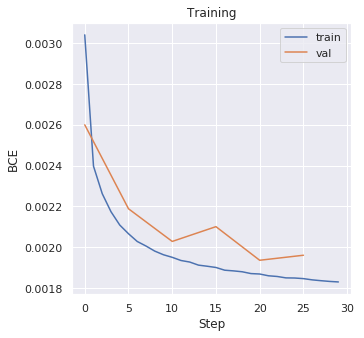

In [13]:
sns.set()
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 5, 5), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('BCE')
plt.legend()
plt.grid(True)

In [9]:
# Model save
# Sample / Generate some images

In [14]:
torch.save(model.state_dict(), 'models/pixelcnn.pt')

In [11]:
model = PixelCNN(128, 3*4)
model.load_state_dict(torch.load('models/pixelcnn.pt'))
model = model.cuda() if use_cuda else model

model.eval()

PixelCNN(
  (network): Sequential(
    (0): MaskedConv2d(3, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualBlock(
      (network): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaskedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
    )
    (4): ResidualBlock(
      (network): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, m

In [48]:
grid = torch.Tensor(10, 3, 28, 28)
grid.fill_(0)

grid = grid.cuda() if use_cuda else grid

model.eval()
for i in range(28):
    for j in range(28):
        _, sm_out = model(grid)
        probs = sm_out[:, :, i, j]
        grid[:, :, i, j] = torch.multinomial(probs, 1).float()
        
im_grid = grid.permute(0, 2, 3, 1).cpu().detach().numpy()

In [49]:
im_grid.shape

(10, 28, 28, 3)

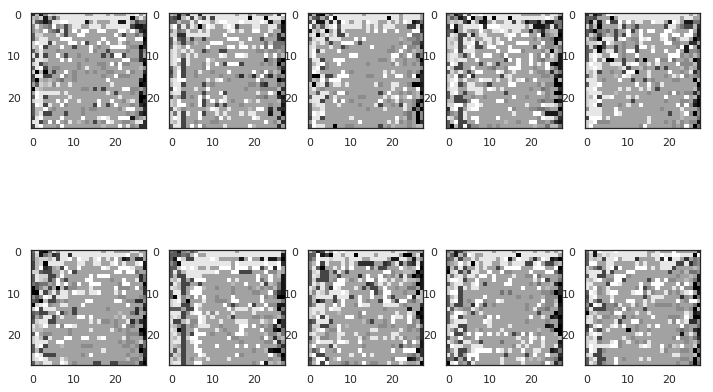

In [60]:
# fix this
import cv2
plt.rcParams['figure.figsize'] = 12, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        im = im_grid[i, :, :, :].reshape(28, 28, 3) / 255.
        im = (im - np.min(im)) / (np.max(im) - np.min(im))
        axis[(i >= 5) * 1, i % 5].imshow(im, cmap='viridis')
plt.show()